## **Section 4.2: Effect of Injection Rate and Victim Setting**

- With this experiment, we determined the effect that the injection rate (`1`, `2`, `3`, `4`, `5`, and `6` per second) and the hardware, network, and geolocation setting of the victim have on the achieved `HS_DESC` lookup rate.
- Before this experiment, we had fixed `60 seconds` as the attack duration, `script` (called `js` below) as the embedded subresource type, and `v2` as the onion service version to generate.
- The data was collected across `9` public cloud machines in `3` different geolocations and on `3` different network configurations. We also included our university desktop machine without network caps.
- The list of `100` sampled guards we used for all runs is: `2020-09-22-18-36-48_guards_num_sampled_from_guard_prob-100.csv`.
- For each of the `10` victim settings and each of the `100` sampled guards, we ran the attack script `3` times per each of the `6` injection rates (`1`, `2`, `3`, `4`, `5`, and `6`).
- We thus expect to have `10 * 100 * 3 * 6 = 18,000` result folders. However, due to some experiments not completing, we see a few less result folders in each experiment setting (`17,163`).

### Locations

- Singapore, Singapore
- New York City, US
- Frankfurt, Germany
- University (Leuven, Belgium)

### Machine Profiles

- Weak machine: 2 vCPUs, 2 GB RAM, 60 GB SSD
- Regular machine: 4 vCPUs, 8 GB RAM, 160 GB SSD
- Powerful machine: 8 vCPUs, 16 GB RAM, 320 GB SSD
- University desktop: 8 vCPUs, 64 GB RAM

### Network Profiles

- Slow network: 10 MBit/s down, 1 MBit/s up; latency: normal distribution with 30 ms mean, 10 ms stddev; packet loss: 0.5%, 25% correlation
- Medium network: 50 MBit/s down, 10 MBit/s up; latency: normal distribution with 20 ms mean, 5 ms stddev; packet loss: 0.25%, 25% correlation
- Fast network: 150 MBit/s down, 50 MBit/s up; latency: normal distribution with 10 ms mean, 1 ms stddev, packet loss: 0%, 0% correlation
- Uncapped network: line speed of university network connection available at office workplace, no bandwidth/latency/packet loss shaping

In [1]:
import csv
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from os.path import abspath, dirname, join, basename, isfile

In [2]:
DATA_DIR = abspath("./3_data_injection-rate_victim-setting")
EXPERIMENT_PARAMS_JSON = "experiment.json"

In [3]:
def load_from_json(json_path):
    return json.loads(open(json_path).read())


def load_from_csv(csv_path):
    data = []

    with open(csv_path, "r", newline="") as csv_fp:

        reader = csv.DictReader(csv_fp)

        for row in reader:
            data.append(row)

    return data

In [4]:
# Should yield a little less than 300 for each configuration and 17,163 in total.
! ls $DATA_DIR | grep "COMPLETED" | cut -d "_" -f 5,6 | sort | uniq -c
! ls $DATA_DIR | grep "COMPLETED" | wc -l

    297 doclient-fra1-client-fast_1.0-v2-js-60s
    295 doclient-fra1-client-fast_2.0-v2-js-60s
    293 doclient-fra1-client-fast_3.0-v2-js-60s
    291 doclient-fra1-client-fast_4.0-v2-js-60s
    289 doclient-fra1-client-fast_5.0-v2-js-60s
    286 doclient-fra1-client-fast_6.0-v2-js-60s
    297 doclient-fra1-client-medium_1.0-v2-js-60s
    297 doclient-fra1-client-medium_2.0-v2-js-60s
    296 doclient-fra1-client-medium_3.0-v2-js-60s
    297 doclient-fra1-client-medium_4.0-v2-js-60s
    297 doclient-fra1-client-medium_5.0-v2-js-60s
    297 doclient-fra1-client-medium_6.0-v2-js-60s
    299 doclient-fra1-client-slow_1.0-v2-js-60s
    298 doclient-fra1-client-slow_2.0-v2-js-60s
    294 doclient-fra1-client-slow_3.0-v2-js-60s
    299 doclient-fra1-client-slow_4.0-v2-js-60s
    299 doclient-fra1-client-slow_5.0-v2-js-60s
    295 doclient-fra1-client-slow_6.0-v2-js-60s
    276 doclient-nyc1-client-fast-3_1.0-v2-js-60s
    276 doclient-nyc1-client-fast-3_2.0-v2-js-60s
    277 doclient-nyc1-cl

#### How many victim lookups (`HS_DESC` lookups with `404 Not Found` response) did we see?

* The following should yield: `9,751,286`.
* In case Jupyter complains about exceeding the maximum number of arguments, please run the command in your system's terminal.

In [5]:
%%bash
{ grep -r "hsdesc_notfound_cnt" ./3_data_injection-rate_victim-setting | tr -s " " | cut -d " " -f 3 | tr -s ",\n" "+"; printf "0\n"; } | bc

9751286


In [6]:
result_tuples = []

# Read in all result.json and experiment.json files.
for results_json in glob(join(DATA_DIR, "*COMPLETED", "results.json")):
    
    exp_json = join(dirname(results_json), EXPERIMENT_PARAMS_JSON)
    if not isfile(exp_json):
        continue

    exp_params = load_from_json(exp_json)
    results = load_from_json(results_json)
    results.update(exp_params)
    result_tuples.append(results)

# Create the dataframe from the list of dicts.
df = pd.DataFrame.from_records(result_tuples)

In [7]:
print(len(df))
pd.set_option('display.max_columns', None)
df.head(15)

17163


,run_time_sec,circ_built_per_sec,hsdesc_notfound_per_sec,circ_cnt,circ_built_cnt,circ_failed_cnt,circ_undetermined_cnt,hsdesc_cnt,hsdesc_recvd_cnt,hsdesc_notfound_cnt,hsdesc_other_cnt,failure_guard_is_hsdir_cnt,failure_guard_is_hsdir_path_attempts_cnt,start_time,tag,user,host,tbb,tbb_version,adv_page,chosen_addr_file,attack_duration,log_level,num_parallel,auto_start,onion_ver,resource_type,rate_per_sec,guard_fp,guard_or_ip,guard_or_port,guard_dir_ip,guard_dir_port,circuit_log_interval,worker_buffer_time,main_tor_buffer_time,main_worker_buffer_time,excluded_circ_purposes,additional_torrc_params,cpu_cores_num,mem_total_kb,tc_ifb0_conf,tc_eth0_conf
0,60.459,5.325923,5.028201,345,322,14,9,322,1,304,17,1.0,189.0,2020-09-22 16:49:55,MAX_HSDESC_RATE,doclient,fra1-client-slow,/home/doclient/tor-browser_en-US/,9.5.3,/home/doclient/tor-dos-attack/src/guard-discov...,/home/doclient/tor-dos-attack/src/guard-discov...,60,INFO,1,True,2,js,1.0,7A3E534C033E3836BD5AF223B642853C502AB33A,5.39.69.166,9001,5.39.69.166,9030,1,15,7,15,[GENERAL],{},NaN,NaN,NaN,NaN
1,59.542,4.400255,4.282691,279,262,9,8,282,1,255,26,1.0,5547.0,2020-09-22 16:51:18,MAX_HSDESC_RATE,doclient,fra1-client-slow,/home/doclient/tor-browser_en-US/,9.5.3,/home/doclient/tor-dos-attack/src/guard-discov...,/home/doclient/tor-dos-attack/src/guard-discov...,60,INFO,1,True,2,js,1.0,BF0FB582E37F738CD33C3651125F2772705BB8E8,148.251.190.229,9010,148.251.190.229,9030,1,15,7,15,[GENERAL],{},NaN,NaN,NaN,NaN
2,59.043,5.470589,5.216537,346,323,17,6,323,1,308,14,0.0,1066.0,2020-09-22 16:52:41,MAX_HSDESC_RATE,doclient,fra1-client-slow,/home/doclient/tor-browser_en-US/,9.5.3,/home/doclient/tor-dos-attack/src/guard-discov...,/home/doclient/tor-dos-attack/src/guard-discov...,60,INFO,1,True,2,js,1.0,2AA5F598F9A1812F01CD99E3B59BB87362ED7438,144.76.200.80,9001,none,none,1,15,7,15,[GENERAL],{},NaN,NaN,NaN,NaN
3,59.017,5.422166,5.151058,353,320,21,12,322,1,304,17,NaN,NaN,2020-09-22 16:54:05,MAX_HSDESC_RATE,doclient,fra1-client-slow,/home/doclient/tor-browser_en-US/,9.5.3,/home/doclient/tor-dos-attack/src/guard-discov...,/home/doclient/tor-dos-attack/src/guard-discov...,60,INFO,1,True,2,js,1.0,4B351545DD58473F36B0A20E5500AC6ED51E8CD5,90.145.175.245,9001,90.145.175.245,9030,1,15,7,15,[GENERAL],{},NaN,NaN,NaN,NaN
4,59.059,5.486039,5.265921,358,324,27,7,329,1,311,17,0.0,1589.0,2020-09-22 16:55:27,MAX_HSDESC_RATE,doclient,fra1-client-slow,/home/doclient/tor-browser_en-US/,9.5.3,/home/doclient/tor-dos-attack/src/guard-discov...,/home/doclient/tor-dos-attack/src/guard-discov...,60,INFO,1,True,2,js,1.0,77A56CB237740E24AEA2D61C8C8936232AFC1BD8,54.36.227.247,443,54.36.227.247,80,1,15,7,15,[GENERAL],{},NaN,NaN,NaN,NaN
5,59.049,5.334553,5.131332,425,315,98,12,323,1,303,19,0.0,629.0,2020-09-22 16:56:51,MAX_HSDESC_RATE,doclient,fra1-client-slow,/home/doclient/tor-browser_en-US/,9.5.3,/home/doclient/tor-dos-attack/src/guard-discov...,/home/doclient/tor-dos-attack/src/guard-discov...,60,INFO,1,True,2,js,1.0,CD39C258265B25EAA4ABA4FDCB2DF98104CAA362,94.130.200.167,443,94.130.200.167,80,1,15,7,15,[GENERAL],{},NaN,NaN,NaN,NaN
6,58.889,5.960366,5.433952,366,351,10,5,332,1,320,11,0.0,1.0,2020-09-22 16:58:14,MAX_HSDESC_RATE,doclient,fra1-client-slow,/home/doclient/tor-browser_en-US/,9.5.3,/home/doclient/tor-dos-attack/src/guard-discov...,/home/doclient/tor-dos-attack/src/guard-discov...,60,INFO,1,True,2,js,1.0,E3D61BAEA0B7CB12CACEDC8821C520557BDFCEA3,144.76.107.94,8080,144.76.107.94,8000,1,15,7,15,[GENERAL],{},NaN,NaN,NaN,NaN
7,59.055,5.554144,5.300144,350,328,16,6,327,1,313,13,0.0,684.0,2020-09-22 16:59:37,MAX_HSDESC_RATE,doclient,fra1-client-slow,/home/doclient/tor-browser_en-US/,9.5.3,/home/doclient/tor-dos-attack/src/guard-discov...,/home/doclient/tor-dos-attack/src/guard-discov...,60,INFO,1,True,2,js,1.0,F8DE8132E599A194E20DDB738AF64A7200CD5949,144.76.196.92,9001,144.76.196.92,9090,1,15,7,15,[GENERAL],{},NaN,NaN,NaN,NaN
8,60.705,5.040771,4.711309,334,306,19,9,306,1,286,19,1.0,2317.0,2020-09-22 17:01:00,MAX_HSDESC_RATE,d

In [8]:
print(df.host.unique())
df.host = df.host.replace(["sgp1-client-slow", "nyc1-client-slow", "fra1-client-slow",
                            "sgp1-client-medium", "nyc1-client-medium", "fra1-client-medium",
                            "sgp1-client-fast", "nyc1-client-fast", "fra1-client-fast",
                            "lnx-desktop"],
                          ["SGP, weak, slow", "NYC, weak, slow", "FRA, weak, slow",
                            "SGP, regular, medium", "NYC, regular, medium", "FRA, regular, medium",
                            "SGP, powerful, fast", "NYC, powerful, fast", "FRA, powerful, fast",
                            "Uni, Desktop, no cap"])
print(df.host.unique())

['fra1-client-slow' 'sgp1-client-slow' 'fra1-client-medium'
 'sgp1-client-medium' 'fra1-client-fast' 'sgp1-client-fast'
 'nyc1-client-fast' 'nyc1-client-medium' 'nyc1-client-slow' 'lnx-desktop']
['FRA, weak, slow' 'SGP, weak, slow' 'FRA, regular, medium'
 'SGP, regular, medium' 'FRA, powerful, fast' 'SGP, powerful, fast'
 'NYC, powerful, fast' 'NYC, regular, medium' 'NYC, weak, slow'
 'Uni, Desktop, no cap']


In [9]:
# Ensure that no measurement sees more HS_DESC lookups per
# second than it sees built circuits per second. Such occurrence
# would violate physics.
for _, row in df.iterrows():
    assert not (row["circ_built_per_sec"] < row["hsdesc_notfound_per_sec"])
    
    if row["circ_built_per_sec"] == row["hsdesc_notfound_per_sec"]:
        print("We have a row in which CIRC_BUILT_PER_SEC={} equals HSDESC_NOTFOUND_PER_SEC={}".format(row["circ_built_per_sec"], row["hsdesc_notfound_per_sec"]))

We have a row in which CIRC_BUILT_PER_SEC=0.0 equals HSDESC_NOTFOUND_PER_SEC=0.0
We have a row in which CIRC_BUILT_PER_SEC=0.0 equals HSDESC_NOTFOUND_PER_SEC=0.0


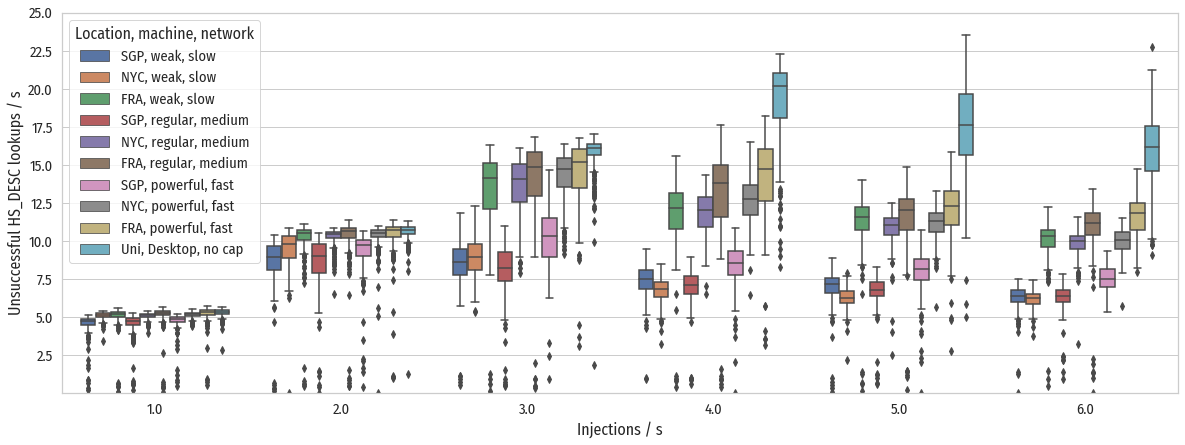

In [10]:
# This command is used to generate the Figure 10 in Appendix B.

plt.figure(figsize=(20, 7))

sns.set()
sns.set(style="whitegrid", font_scale=1.33)
sns.set_style({"font.family": "Fira Sans Condensed"})

graph = sns.boxplot(data=df, x="rate_per_sec", y="hsdesc_notfound_per_sec", hue="host",
                    hue_order=["SGP, weak, slow", "NYC, weak, slow", "FRA, weak, slow",
                            "SGP, regular, medium", "NYC, regular, medium", "FRA, regular, medium",
                            "SGP, powerful, fast", "NYC, powerful, fast", "FRA, powerful, fast",
                            "Uni, Desktop, no cap"],
                    palette=sns.color_palette("deep"))
leg = graph.axes.legend(loc="upper left", title="Location, machine, network")

graph.set(ylim=(0.0, 25.0), yticks=(2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5, 25.0))

plt.xlabel("Injections / s")
plt.ylabel("Unsuccessful HS_DESC lookups / s")

plt.show()

In [11]:
print(df.groupby(["rate_per_sec"]).hsdesc_notfound_per_sec.describe()\
      .to_latex(columns=["25%", "50%", "75%", "max"], float_format="{:0.3f}".format, multirow=True, bold_rows=True))

\begin{tabular}{lrrrr}
\toprule
{} &   25\% &    50\% &    75\% &    max \\
\textbf{rate\_per\_sec} &       &        &        &        \\
\midrule
\textbf{1.0         } & 4.845 &  5.103 &  5.288 &  5.711 \\
\textbf{2.0         } & 9.432 & 10.226 & 10.664 & 11.380 \\
\textbf{3.0         } & 9.222 & 12.403 & 15.188 & 17.031 \\
\textbf{4.0         } & 7.638 & 10.912 & 13.694 & 22.313 \\
\textbf{5.0         } & 7.245 & 10.211 & 12.056 & 23.527 \\
\textbf{6.0         } & 6.713 &  9.455 & 10.936 & 22.757 \\
\bottomrule
\end{tabular}



In [12]:
# Based on the first part of the host identifier (the region part),
# assign each row one of four region identifiers as a new column.
df["region"] = df.apply(lambda row: row.host.split(", ")[0], axis=1)

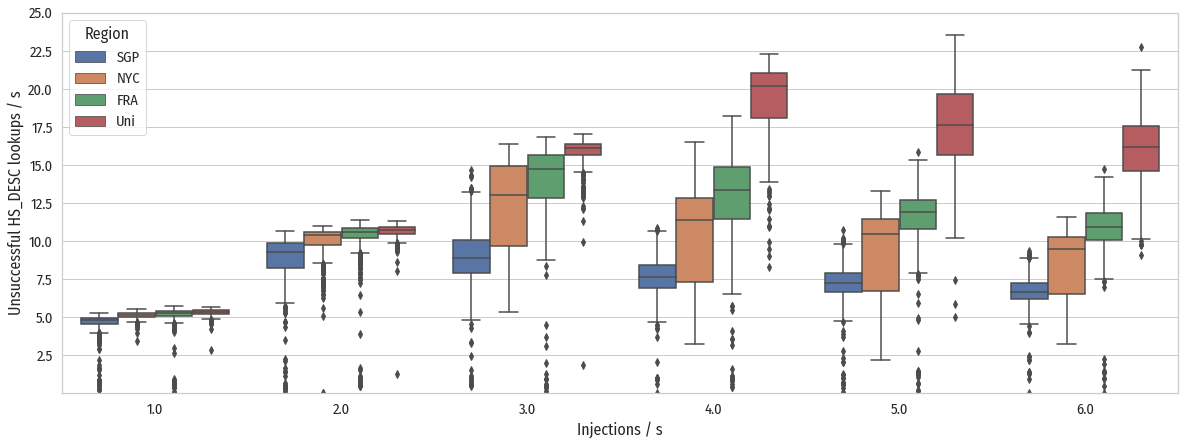

In [13]:
plt.figure(figsize=(20, 7))

sns.set()
sns.set(style="whitegrid", font_scale=1.33)
sns.set_style({"font.family": "Fira Sans Condensed"})

graph = sns.boxplot(data=df, x="rate_per_sec", y="hsdesc_notfound_per_sec", hue="region",
                    hue_order=["SGP", "NYC", "FRA", "Uni"],
                    palette=sns.color_palette("deep"))
leg = graph.axes.legend(loc="upper left", title="Region")

graph.set(ylim=(0.0, 25.0), yticks=(2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5, 25.0))

plt.xlabel("Injections / s")
plt.ylabel("Unsuccessful HS_DESC lookups / s")

plt.show()

In [14]:
print(df.groupby(["region"]).hsdesc_notfound_per_sec.describe()\
      .to_latex(columns=["25%", "50%", "75%", "max"], float_format="{:0.3f}".format, multirow=True, bold_rows=True))

\begin{tabular}{lrrrr}
\toprule
{} &    25\% &    50\% &    75\% &    max \\
\textbf{region} &        &        &        &        \\
\midrule
\textbf{FRA   } &  9.575 & 10.990 & 13.002 & 18.222 \\
\textbf{NYC   } &  6.348 &  9.942 & 11.148 & 16.493 \\
\textbf{SGP   } &  6.132 &  7.354 &  8.714 & 14.644 \\
\textbf{Uni   } & 10.654 & 15.572 & 17.667 & 23.527 \\
\bottomrule
\end{tabular}

